<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> **Project SQL. HeadHunter**
   

It is necessary to analyze vacancies from the HeadHunter job search aggregator using SQL queries to the database.  
All required tables are in the public database schema below.

[![Pj2-SQL.png](https://i.postimg.cc/YS74hGmk/Pj2-SQL.png)](https://postimg.cc/cvD1zJm5)

In [242]:
# load libraries
import pandas as pd
import psycopg2

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
# switch off the system warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

There was connection parameters here.

In [182]:
# provide the connection
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

In [116]:
def get_df(query, connect):
    """function to get dataframe by a sql-query"""
    
    df = pd.read_sql_query(query, connect)
    
    return df

## <center> **Preliminary Data Analysis**

In [146]:
# find the total number of vacancies
query_vacancies = f'''
    select count(*) as vacancies_count
    from vacancies
'''

# create a df
count_vacancies = get_df(query_vacancies, connection)
count_vacancies

,vacancies_count
0,49197


In [145]:
# find the total number of employers
query_employers = f'''
    select count(name) as employers_count
    from employers
'''

count_employers = get_df(query_employers, connection)
count_employers

,employers_count
0,23501


In [148]:
# find the number of regions represented
query_areas = f'''
    select count(areas) as areas_count
    from areas
'''

count_areas = get_df(query_areas, connection)
count_areas

,areas_count
0,1362


In [348]:
# let's count the number of industries
query_industries = f'''
    select count(name) as industries
    from industries
'''

count_industries = get_df(query_industries, connection)
count_industries

,industries
0,294


It's time to draw some conclusions. Let's do it by a graph.

In [155]:
# create a request with union values
query_primary_analysis = f'''
    select
        'Vacancies' as "HeadHunter",
        count(*) as "Amount"
    from vacancies
            union all
    select 
        'Employers',
        count(name)
    from employers
            union all
    select 
        'Areas',
        count(areas)
    from areas
            union all
    select
        'Industries',
        count(name)
    from industries
'''

# display the result
primary_analysis = get_df(query_primary_analysis, connection)
primary_analysis

,HeadHunter,Amount
0,Vacancies,49197
1,Employers,23501
2,Areas,1362
3,Industries,294


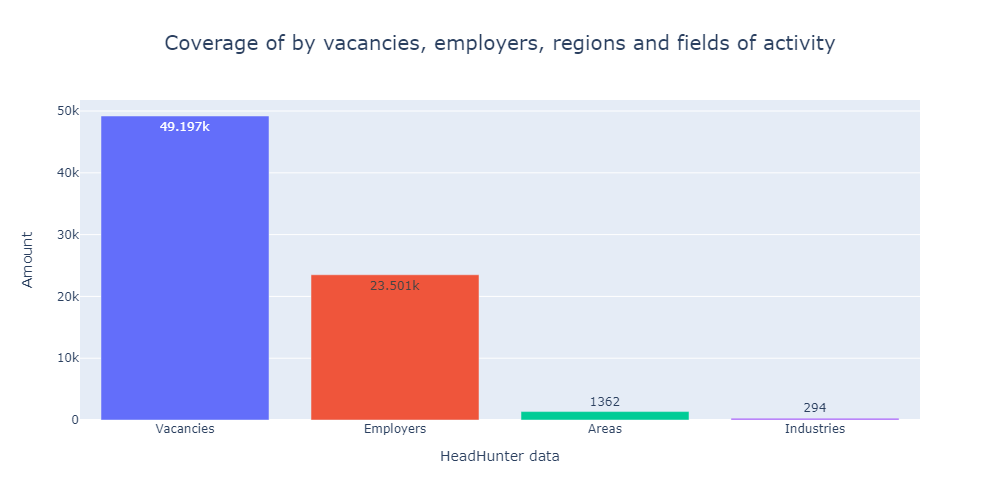

In [167]:
# build a graph
hh_bar = px.bar(
    data_frame=primary_analysis,
    x='HeadHunter',
    y='Amount',
    color='HeadHunter',
    text_auto=True,
    title='Coverage of by vacancies, employers, regions and fields of activity',
    width=1000
)

# add a litle changes
hh_bar.update_layout(
    xaxis_title='HeadHunter data',
    title_font_size=20,
    title=dict(x=.5, xanchor='center'),
    showlegend=False
)

# picturaze it
hh_bar.show('png')

HeadHunter database contains about 50 thousand vacancies from more than 20 thousand employers with almost 300 fields of activity. At the same time, 1362 regions are represented in this platform.

## <center> **Job Analysis**

Find out the number of vacancies by region.

In [184]:
# pull request
query_vacancies_area = f'''
    select
        a.name,
        count(v.name) as vacancies_count
    from vacancies as v
    join areas as a on v.area_id=a.id
    group by a.name
    order by count(v.name) desc
'''

# create a df
vacancies_in_area = get_df(query_vacancies_area, connection)

# displya top 5
vacancies_in_area.head()

,name,vacancies_count
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


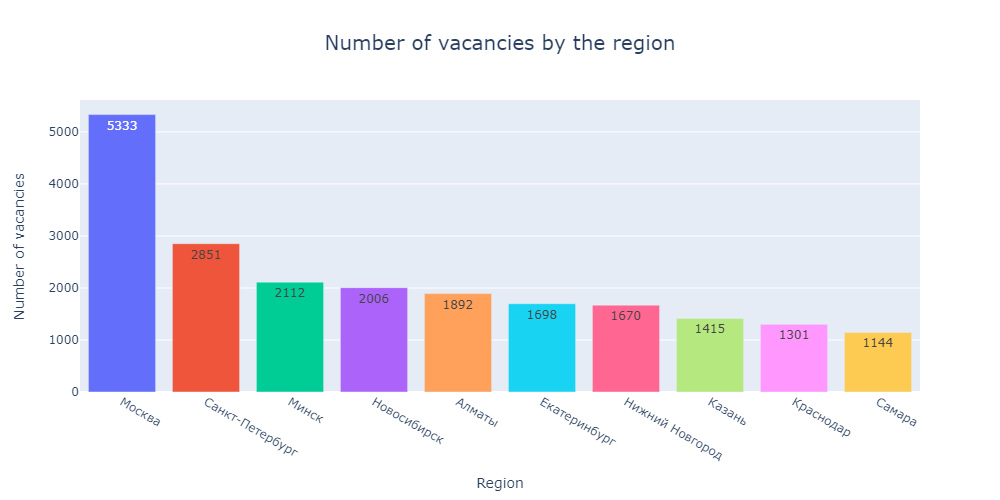

In [188]:
# reduce this sample to top 10
vacancies_in_area = vacancies_in_area.head(10)

# build a graph
vacancies_in_area_bar = px.bar(
    data_frame=vacancies_in_area,
    x='name',
    y='vacancies_count',
    color='name',
    text_auto=True,
    title='Number of vacancies by the region',
    width=1000
)

# add names
vacancies_in_area_bar.update_layout(
    title=dict(x=.5, xanchor='center'),
    xaxis_title='Region',
    yaxis_title='Number of vacancies',
    title_font_size=20,
    showlegend=False
)

# show the graph
vacancies_in_area_bar.show('png')

Let's find out the number of vacancies in which at least one of the salary range is filled.

In [350]:
# pull the request
query_salary_range = f'''
    select
        count(*) as salary_cap_filled
    from vacancies
    where (salary_from is not null)
        or (salary_to is not null)
'''

# display it
have_salary_range = get_df(query_salary_range, connection)
have_salary_range

,salary_cap_filled
0,24073


Let's calculate the average value of the lower and the upper bound of a salary range.

In [190]:
# pull the request
query_avg_salary_bound = f'''
    select
        'Average lower bound' as "Salary range",
        round(avg(salary_from)) avg_salary
    from vacancies
    where (salary_from is not null)
        or (salary_to is not null)
    
        union all
    
    select
        'Average upper bound',
        round(avg(salary_to))
    from vacancies
    where (salary_from is not null)
        or (salary_to is not null)
'''

# display it
avg_salary_bound = get_df(query_avg_salary_bound, connection)
avg_salary_bound

,Salary range,avg_salary
0,Average lower bound,71065.0
1,Average upper bound,110537.0


Find out the number of vacancies for all options for a combination of work schedule and type of employment.

In [191]:
# pull the request
query_schedule_employment = f'''
    select
        schedule,
        employment,
        count(id) as vacancies_count
    from vacancies
    group by schedule, employment
    order by count(id) desc
'''

# display the top 5
schedule_employment = get_df(query_schedule_employment, connection)
schedule_employment.head()

,schedule,employment,vacancies_count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940


Let's estimate the distribution of vacancies by work experience.

In [192]:
# pull the request
query_experience = f'''
    select
        experience,
        count(id) as vacancies_count
    from vacancies
    group by experience
    order by count(id)
'''

# display the result
experience = get_df(query_experience, connection)
experience

,experience,vacancies_count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


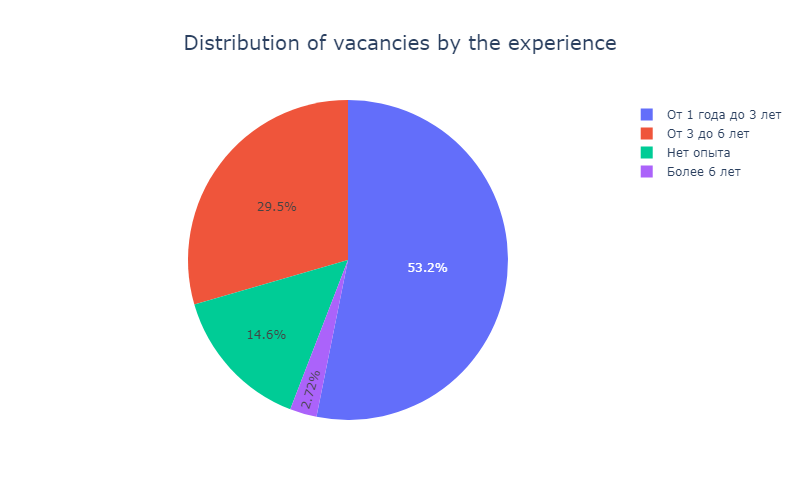

In [352]:
# build the graph
experience_pie = px.pie(
    data_frame=experience,
    values='vacancies_count',
    names='experience',
    title='Distribution of vacancies by the experience',
    width=800
)

# add a little changes
experience_pie.update_layout(
    title=dict(x=.5, xanchor='center'),
    title_font_size=20
)

# show the graph
experience_pie.show('png')

Conclusions for this stage:  
- the largest number of vacancies in large cities with a million inhabitants, with 1st place - the capital of Russia, 3rd - the capital of Belarus, and 5th - Kazakhstan. Thus, the CIS countries are integrated into the search for specialists from Russia;
- in less than half of the cases, the vacancy has at least one of the values of the salary range;
- the average salary range in this database is from 71 to 110 thousand rubles (1000-1600$);
- about 70% are looking for work in the office, about 15% are full-time remote work, and the rest of the categories are much less common;
- less than 3% of vacancies are designed for experienced specialists (> 6y), less than 15% of companies are ready for a specialist without experience, and the main search group is middle specialists with more than 1 year of experience.

## <center> **Employer Analysis**

Display the top employers by the number of vacancies.

In [214]:
# pull the request
query_top_employers = f'''
    select
        e.name as employer,
        count(v.id) as vacancies_count
    from vacancies as v
    join employers as e on v.employer_id=e.id
    group by e.name
    order by count(v.id) desc
    limit 10
'''

# display the result
top_employers = get_df(query_top_employers, connection)
top_employers

,employer,vacancies_count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331
5,ИК СИБИНТЕК,327
6,МТС,292
7,DataArt,247
8,Совкомбанк Технологии,204
9,Первый Бит,176


Write a query that for each region will display the number of employers and vacancies in it.

In [216]:
# pull the request
query_employer_in_area = f'''
    select
        distinct a.name as area,
        count(distinct v.employer_id) as employers_count,
        count(v.id) as vacancies_count
    from areas as a
    left join vacancies as v on a.id=v.area_id
    group by a.id
    order by employers_count desc
    limit 10
'''

employer_in_area = get_df(query_employer_in_area, connection)
employer_in_area

,area,employers_count,vacancies_count
0,Москва,2320,5333
1,Санкт-Петербург,1451,2851
2,Минск,851,2112
3,Новосибирск,802,2006
4,Алматы,798,1892
5,Екатеринбург,742,1698
6,Нижний Новгород,657,1670
7,Казань,609,1415
8,Краснодар,578,1301
9,Ростов-на-Дону,487,1131


For each employer, count the number of regions in which he publishes his vacancies.

In [219]:
# pull the request
query_employers_spread = f'''
    select
        e.name,
        count(distinct v.area_id) as areas_count
    from employers as e
    join vacancies as v on v.employer_id=e.id
    group by e.name
    order by count(distinct v.area_id) desc
    limit 10
'''

# display the result
employers_spread = get_df(query_employers_spread, connection)
employers_spread

,name,areas_count
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
5,Совкомбанк,63
6,МТС,55
7,"ЭФКО, Управляющая компания",49
8,Почта России,48
9,КРОН,48


Write a query to count the number of employers who do not have a field of activity

In [353]:
# pull the request
query_industries_null = f'''
    select
        count(*) as empty_industries
    from employers as e 
    left join employers_industries as ei on e.id=ei.employer_id
    where industry_id is null
'''

count_null_industries = get_df(query_industries_null, connection)
count_null_industries

,empty_industries
0,8419


Write a query to find out companies that have four areas of activity.

In [354]:
# pull the request
query_employer_industries = f'''
    select
        e.name as company_name,
        count(ei.industry_id) as industries_count
    from employers as e 
    left join employers_industries as ei on e.id=ei.employer_id
    group by e.name
    having count(ei.industry_id)=4
    order by e.name
    limit 10
'''

# display the result
employer_industries = get_df(query_employer_industries, connection)
employer_industries

,company_name,industries_count
0,101 Интернет,4
1,21vek.by,4
2,2ГИС,4
3,2К,4
4,4 пикселя +,4
5,5lb,4
6,5 Армия,4
7,741 Studios,4
8,AAEngineering Group,4
9,ADAPTER,4


Find out how many employers have Software Development listed as their occupation.


In [355]:
# pull the request
query_count_software_dev = f'''
    select
        count(*) as software_dev
    from employers_industries as ei
    join employers as e on e.id=ei.employer_id
    join industries as i on i.id=ei.industry_id
    where i.name like 'Разработка программного обеспечения'
'''

# display the result
count_software_dev = get_df(query_count_software_dev, connection)
count_software_dev

,software_dev
0,3553


For the Yandex company, display a list of million-plus regions in which the company's vacancies are presented, along with the number of vacancies in these regions.  
Also add the line Total with the total number of vacancies in the company.

In [357]:
# pull this request
query_yandex = f'''
    (select
        a.name as area_name,
        count(v.id) as vacancies_count
    from vacancies as v
    join employers as e on v.employer_id=e.id
    join areas as a on v.area_id=a.id
    where e.name='Яндекс'
        and a.name in ('Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', -- million-plus cities
        'Казань', 'Нижний Новгород', 'Челябинск', 'Красноярск', 'Самара', 'Уфа',
        'Ростов-на-Дону', 'Омск', 'Краснодар', 'Воронеж', 'Пермь', 'Волгоград')
    group by a.name
    order by count(v.id) desc)
    
        UNION ALL 

    select
        'Total',
        count(v.id) as vacancies_count
    from vacancies as v
    join employers as e on v.employer_id=e.id
    join areas as a on v.area_id=a.id
    where e.name='Яндекс'
        and a.name in ('Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', -- million-plus cities
        'Казань', 'Нижний Новгород', 'Челябинск', 'Красноярск', 'Самара', 'Уфа',
        'Ростов-на-Дону', 'Омск', 'Краснодар', 'Воронеж', 'Пермь', 'Волгоград')
    group by e.name
'''

# display the result
yandex = get_df(query_yandex, connection)
yandex

,area_name,vacancies_count
0,Total,485
1,Москва,54
2,Санкт-Петербург,42
3,Екатеринбург,39
4,Нижний Новгород,36
5,Новосибирск,35
6,Воронеж,32
7,Краснодар,30
8,Самара,26
9,Уфа,26


The most common in terms of the number of vacancies and regions covered for searching for employees is Yandex, a leading technology company in Russia.

## <center> **DS Vacancies**

How many jobs are relevant to the data?

In [358]:
# pull the request
query_relevant_data = f'''
    select
        count(*) as data_relevant
    from vacancies
    where lower(name) like '%data%'
        or lower(name) like '%данн%'
'''

# display the result
relevant_data = get_df(query_relevant_data, connection)
relevant_data

,data_relevant
0,1771


How many suitable vacancies are there for a junior/intern data scientist?
 

In [359]:
# pull the request
query_junior_ds = f'''
    select
        count(*) as junior_ds
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
    and name not ilike '%HTML%'
    and (name ilike '%junior%'
            or experience='Нет опыта'
            or employment ilike '%стажировка%')
'''

junior_ds = get_df(query_junior_ds, connection)
junior_ds

,junior_ds
0,51


How many jobs are there for DS that list SQL or Postgres as a key skill?

In [360]:
# pull the request
query_ds_sql_postgres = f'''
    select
        count(*) as sql_postgres_skill
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
        and name not ilike '%HTML%'
        and (key_skills ilike '%postgres' 
        or key_skills ilike '%sql%')
'''

# display the result
ds_sql_postgres = get_df(query_ds_sql_postgres, connection)
ds_sql_postgres

,sql_postgres_skill
0,201


Now let's evaluate how much Python is necessary for a Data Scientist.

In [361]:
# pull the request
query_ds_python = f'''
    select
        count(*) as python_skill
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
    and name not ilike '%HTML%'
    and key_skills ilike '%python%' 
'''

# display the result
ds_python = get_df(query_ds_python, connection)
ds_python

,python_skill
0,351


How many key skills are listed on average in job postings for DS?  
*tab is used as a separator

In [362]:
# pull the request
query_count_key_skills = f'''
    select
        AVG(LENGTH(key_skills) - LENGTH(replace(key_skills, CHR(9), '')) +1) as avg_skills
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
        and name not ilike '%HTML%'
        and key_skills is not null
'''

# sisplay the result
count_key_skills = get_df(query_count_key_skills, connection)
round(count_key_skills, 2)

,avg_skills
0,6.41


Write a query to calculate the average DS salary for each type of experience required  
*we consider vacancies where at least one value is indicated

In [230]:
# pull the request
query_avg_ds_salary = f'''
    select
        experience,
        avg(coalesce((salary_from+salary_to)/2, salary_from, salary_to)) as avg_salary
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
        and name not ilike '%HTML%'
        and key_skills is not null
        and (salary_from is not null
            or salary_to is not null)
    group by experience
'''

# display the result
avg_ds_salary = round(get_df(query_avg_ds_salary, connection))
avg_ds_salary

,experience,avg_salary
0,Нет опыта,74643.0
1,От 1 года до 3 лет,146704.0
2,От 3 до 6 лет,243115.0


Let's evaluate the distribution of vacancies according to the work schedule for DS.

In [231]:
# pull the request
query_ds_schedule = f'''
    select
        schedule,
        count(id)
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
        and name not ilike '%HTML%'
    group by schedule
'''

# display the result
ds_schedule = get_df(query_ds_schedule, connection)
ds_schedule

,schedule,count
0,Гибкий график,43
1,Полный день,322
2,Удаленная работа,115


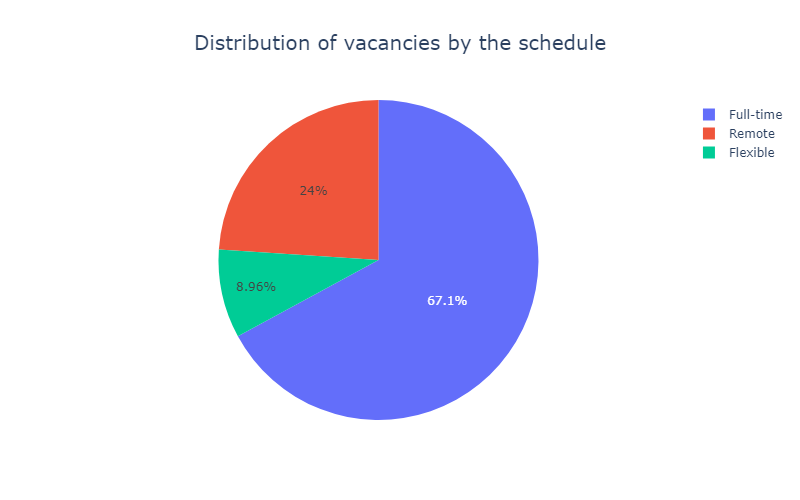

In [363]:
# translate itto english
labels = ['Flexible', 'Full-time', 'Remote']
values = ds_schedule['count'].to_list()

# build a graph
ds_schedule_pie = go.Figure(
    data=[go.Pie(labels=labels, values=values)])

# add some changes
ds_schedule_pie.update_layout(
    title=dict(x=.5, xanchor='center'),
    title_font_size=20,
    title_text='Distribution of vacancies by the schedule',
    width=800
)

# picturaze it
ds_schedule_pie.show('png')

Let's evaluate the distribution of vacancies according to the work experience for DS.

In [244]:
# pull the request
query_ds_experience = f'''
    select
        experience,
        count(id)
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
        and name not ilike '%HTML%'
    group by experience
    order by count(id)
'''

# display the result
ds_experience = get_df(query_ds_experience, connection)
ds_experience

,experience,count
0,Нет опыта,28
1,Более 6 лет,34
2,От 3 до 6 лет,195
3,От 1 года до 3 лет,223


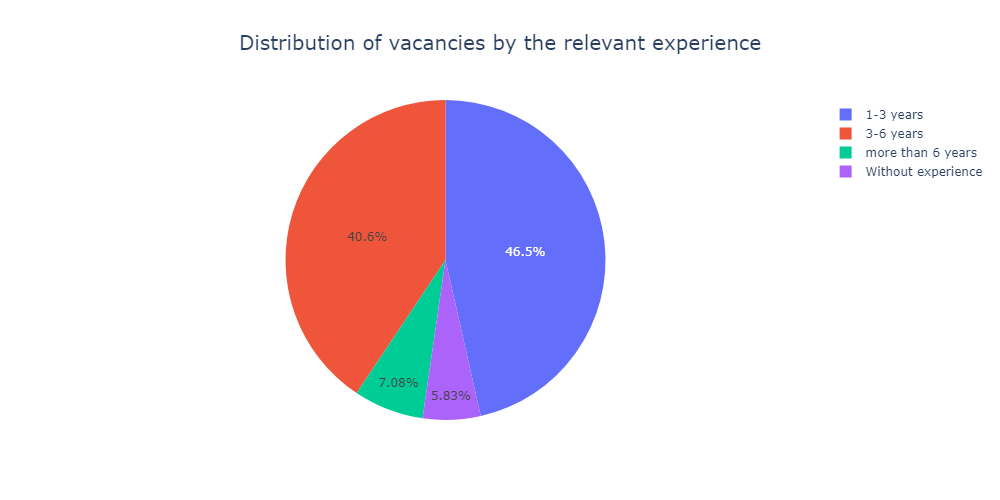

In [246]:
# translate itto english
labels = ['Without experience', 'more than 6 years', '3-6 years', '1-3 years']
values = ds_experience['count'].to_list()

# build a graph
ds_experience_pie = go.Figure(
    data=[go.Pie(labels=labels, values=values)])

# add some changes
ds_experience_pie.update_layout(
    title=dict(x=.5, xanchor='center'),
    title_font_size=20,
    title_text='Distribution of vacancies by the relevant experience',
    width=1000
)

# picturaze it
ds_experience_pie.show('png')

Now let's build a heat map of the number of vacancies depending on experience and schedule.

In [342]:
# pull the request
query_ds_exp_sched = f'''
    select
        experience,
        schedule,
        count(id)
    from vacancies
    where 
        (name ilike '%data scientist%' 
            or name ilike '%data science%'
            or name ilike '%исследователь данных%'
            or name like '%ML%'
            or name ilike '%machine learning%'
            or name ilike '%машинн%обучен%')
    and name not ilike '%HTML%'
    group by experience, schedule
'''

# display the result
ds_exp_sched = get_df(query_ds_exp_sched, connection)
ds_exp_sched

,experience,schedule,count
0,Более 6 лет,Гибкий график,1
1,Более 6 лет,Полный день,6
2,Более 6 лет,Удаленная работа,27
3,Нет опыта,Гибкий график,6
4,Нет опыта,Полный день,19
5,Нет опыта,Удаленная работа,3
6,От 1 года до 3 лет,Гибкий график,12
7,От 1 года до 3 лет,Полный день,170
8,От 1 года до 3 лет,Удаленная работа,41
9,От 3 до 6 лет,Гибкий график,24


In [343]:
def translate_schedule(schedule):
    """function to translate experience into english"""
    
    if schedule == 'Гибкий график':
        schedule = 'Flexible'
        
    if schedule == 'Полный день':
        schedule = 'Full-time'
        
    if schedule == 'Удаленная работа':
        schedule = 'Remote'
    
    return schedule


# transfrom our dataset    
ds_exp_sched['schedule'] = ds_exp_sched['schedule'].apply(translate_schedule)

In [344]:
def translate_experience(experience):
    """function to translate experience into english"""
    
    if experience == 'Более 6 лет':
        experience = 'more than 6 years'
        
    if experience == 'От 3 до 6 лет':
        experience = '3-6 years'
        
    if experience == 'От 1 года до 3 лет':
        experience = '1-3 years'
        
    if experience == 'Нет опыта':
        experience = 'without experience'
    
    return experience

 
# transfrom our dataset     
ds_exp_sched['experience'] = ds_exp_sched['experience'].apply(translate_experience)

In [346]:
# build a pivot table
ds_exp_sched = ds_exp_sched.pivot_table(
    index='experience',
    columns='schedule',
    values='count'
)

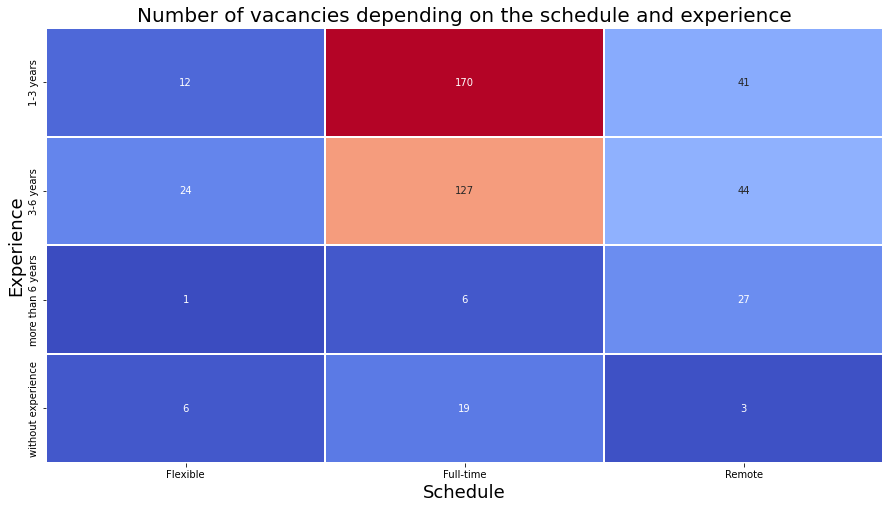

In [347]:
# add axes
fig, ax = plt.subplots(figsize=(15, 8))

# build a heatmap
ds_heatmap = sns.heatmap(
    ds_exp_sched,
    annot=True,
    fmt='.0f',
    linewidths=0.1,
    linecolor="white",
    cmap="coolwarm",
    ax=ax,
    cbar=False
)

# adding axis labels
ds_heatmap.set_title('Number of vacancies depending on the schedule and experience', fontsize=20)
ds_heatmap.set_xlabel('Schedule', fontsize=18)
ds_heatmap.set_ylabel('Experience', fontsize=18);

Conclusions for this stage:
- there are very few vacancies for junior DS without relevant experience;
- on average, the company declares 6-7 key skills for DS;
- one of the most important, in fact mandatory, is knowledge of Python and SQL;
- junior DS without experience can apply for an average of 75 thousand rubles (1k$);
- less than a quarter of vacancies are designed to search for remote employees;
- almost all vacancies are aimed at finding middle-senior level specialists;
- the higher the experience, the more employers are ready to provide a remote work format.

### <center> **General conclusion**

It is very difficult for a beginner (noob) data scientist to find a job, but i will try.